# Modeling

## Running Mode

In [538]:
#MODE = 'training' # training model + evaluation
MODE = 'evaluation' # loading existing model + evaluation

## Reference

The code in this notebook is adapted and modified from the following Youtube tutorial: https://www.youtube.com/watch?v=doDUihpj6ro 

## Usage

In this notebook, an LSTM based neural network model can be trained with data generated by the notebook "1_Example-Data-Generation.ipynb"

The path to the input data `DATA_PATH` is set to 'MP_Data_test'. Change it, if you want to use different / your own data generated with "1_Example-Data-Generation.ipynb". 

The weights of the trained final model are saved with the name `model_name = 'first_model_whoop_whoop.h5'`. Change it, if you want ;)

Further, weights are saved in checkpoints every 100 epochs (change if needed). 

## 1. Install and Import Dependencies

### Install Dependencies

In [539]:
%pip install tensorflow-macos opencv-python mediapipe-silicon sklearn matplotlib
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib # original code line from tutorial (he used a Windows system)

Note: you may need to restart the kernel to use updated packages.


### Import Dependencies

In [540]:
# general 
import numpy as np
import pandas as pd
import os # easier file path handling

# for device camera feed
import cv2 # opencv
from matplotlib import pyplot as plt # imshow for easy visualization
import time # to insert breaks / "sleep" in between frames
import mediapipe as mp # for accessing and reading from device camera

# for data pre-processing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# for model building and training
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

# for model evaluation
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, accuracy_score

## 2. Preprocess Data and Create Labels and Features

### Some global setup (edit to your needs)

In [541]:
# path for input data
#DATA_PATH = os.path.join('MP_Data')
DATA_PATH = os.path.join('../data/')

# X and y filenames
X_fname = 'X-data.npy'
y_fname = 'y-data.npy'

# set random seed
RSEED = 24

# name for saving the trained model
model_name = 'Easter_model_10signs_j_test'

# directory to save tensorflow callbacks (logs)
log_dir = os.path.join('./Modeling_logs', model_name)

# for tensorboard callbacks
tb_callback = TensorBoard(log_dir=log_dir)

# for checkpoint callbacks
checkpoint_name = "cp-{epoch:04d}.ckpt"
checkpoint_path = os.path.join(log_dir, checkpoint_name)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
   filepath=checkpoint_path, 
   verbose=1, 
   save_weights_only=True,
   # Save weights, every 100 epochs 
   save_freq='epoch', 
   period=100)

# actions to detect (get later from our .json file)
#actions = np.array(['hello', 'thanks', 'iloveyou']) # from tutorial
actions = np.array ( ['alligator', 
                      'radio', 
                      'moon', 
                      'sleep', 
                      'grandpa', 
                      'tiger', 
                      'pencil', 
                      'sleepy', 
                      'grandma', 
                      'chocolate'] ) # from Ronja's kaggle example data

n_sequences = 30 # 30 videos per sequence / word / sign (get it later from input file?)
sequence_length = 30 # each video with 30 frames (get it later from input file?)
n_keypoints = 1086 # kaggle: 1086; tutorial: 1662

label_map = {label:num for num, label in enumerate(actions)} # create label map (dict, later our .json file)

if MODE == 'evaluation': 
   # path to existing model (or checkpoint) for evaluation
   #model_path = 'tutorial/Easter_model_10signs.h5'
   model_path = 'Modeling_logs/Easter_model_10signs_j_test/cp-0800.ckpt' # load model from checkpoint

### Load X and y Data

In [542]:
#loading our preprocessed kaggle data
X = np.load(os.path.join(DATA_PATH, X_fname))
y = np.load(os.path.join(DATA_PATH, y_fname))

### Splitting Train and Test Data

In [543]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=RSEED)

## Build and Train LSTM Neural Network

### Setup Callbacks

### Model building

In [544]:
# setup sequential model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(n_sequences, n_keypoints))) # input_shape=(#sequences, #keypoints)
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax')) # actions.shape[0]: from user-defined actions (see above)

# compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# categorical_crossentropy must be used for multiclass classification model! 

# show summary of model
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 30, 64)            294656    
                                                                 
 lstm_49 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_50 (LSTM)              (None, 64)                49408     
                                                                 
 dense_48 (Dense)            (None, 64)                4160      
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 10)                330       
                                                                 
Total params: 449,450
Trainable params: 449,450
Non-t

### Model fitting

In [545]:
# fit the model if in training mode
if MODE == 'training': 
    # save model weight for every 100 epochs
    model.save_weights(checkpoint_path.format(epoch=10))

    model.fit(X_train, y_train, 
            epochs=2000, 
            callbacks=[tb_callback, cp_callback])
    # advantage of using mediapipe holistic model is you don't need additional data generator to build up a pipeline of data. Training data fits all into memory.
    # 2023-04-07-14-48 run-time: 17m 18.7s

    # model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback, cp_callback], validation_data = (x_test, y_test), verbose=0)

# load an existing model if in evaluation mode
if MODE == 'evaluation': 
    # load model (or checkpoint) for evaluation
    model.load_weights(model_path)


### Tensorboard

Follow these steps to look at the model training (also possible in real-time): 

1. Open the command palette (command+shift+P) in VSCode. 
2. Type in "Python: Launch TensorBoard". 
3. Press "Enter". 
4. Click "Use current working directory" (select another option, if you want to look at logs outside the working directory)
5. If "No dashboards are active for the current data set.", click on the circular arrow in the top right to refresh the dashboard. 
6. In the main dashboard area, you should immediately see plots showing the development of accuracies and losses per epoch. 
7. In the left area you can check and uncheck log files that you want to add or remove from the plots. 

## Prediction

### Optional: Load Checkpoint Model

In [546]:
#checkpoint_path = 'Modeling_logs/Easter_model_10signs_j_test/cp-0800.ckpt'
#model.load_weights(checkpoint_path)

### Predict on test data

In [547]:
# prediction on test data
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 235ms/step


### Looking at a single example prediction

In [548]:
actions[np.argmax(y_pred[0])] # prediction

'pencil'

In [549]:
actions[np.argmax(y_test[0])] # actual

'pencil'

## Evaluation using Accuracy and Confusion Matrix

### Back-converting one-hot codes to labels

In [550]:
# convert one-hot encoded categories back to labels, 
# e.g. 0, 1 and 2 instead of [1,0,0], [0,1,0], [0,0,1]
y_test_original = y_test.copy()
y_test = np.argmax(y_test, axis=1).tolist()

In [551]:
y_pred_original = y_pred.copy()
y_pred = np.argmax(y_pred, axis=1).tolist()

### Accuracy Score

In [552]:
# accuracy score
accuracy_score(y_test, y_pred)

0.9411764705882353

### Multilabel Confusion Matrix

In [553]:
# multilabel confusion matrix 
mcm = multilabel_confusion_matrix(y_test, y_pred)

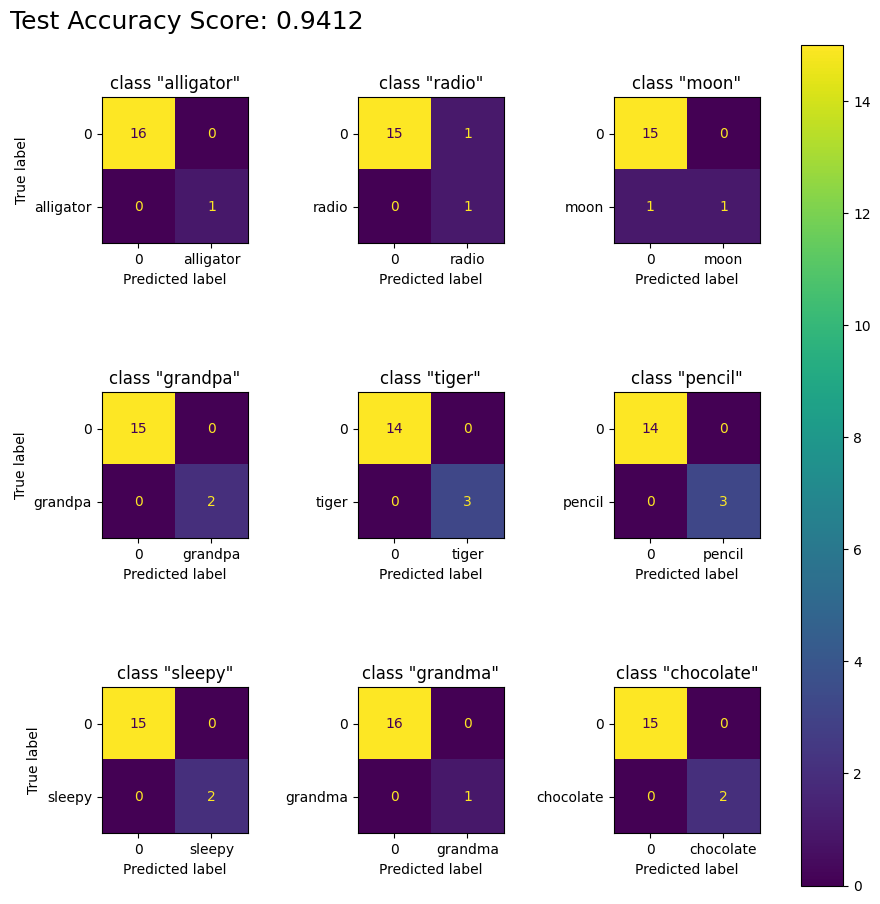

In [554]:
# plotting parameters
labels = np.unique(y_pred) # labels, that are among predictions
ncols = 3 # define plot matrix columns always as 3 
nrows = math.ceil(len(labels)/ncols) # define rows depending on the number of labels / categories

# formatting plotting area
f, axes = plt.subplots(nrows, ncols, figsize=(nrows*3, ncols*3)) # define plot area layout based on pre-defined number of columns and rows
f.text(x=-0.05, y=0.995, 
       s='Test Accuracy Score: {:.4f}'.format(accuracy_score(y_test, y_pred)), 
       fontsize=18) # set plot title to accuracy score in top-left corner
f.tight_layout() # removes some whitespace
axes = axes.ravel() # flatten axes object to later access it as axes[i] with i indicating the heatmap number

# loop over all available categories / labels to plot each confusion matrix
for cat, i in zip(actions[labels], range(len(actions[labels]))): 
    
    # plot current confusion matrix heatmap
    disp = ConfusionMatrixDisplay(mcm[i], display_labels=[0, cat]) # creates confusion matrix display object with categories as labels for positive class and 0 for negative class
    disp.plot(ax=axes[i]) # plot confusion matrix heatmap into corresponding plat matrix position
    disp.ax_.set_title(f'class "{cat}"') # set title for each heatmap as 'class "class name"'

    # formatting single confusion matrix heatmaps
    #if i<len(actions[labels])-ncols: 
    #    disp.ax_.set_xlabel('') # display x label ("Predicted Label") only if it is the last row
    if i%ncols!=0: 
        disp.ax_.set_ylabel('') # display y label ("True Label") only if it is the first column (plot) in each row
    disp.im_.colorbar.remove() # removes all the extra colorbars for each heatmap

# final plotting
plt.subplots_adjust(wspace=0.75) # sets some width spacing
plt.colorbar(disp.im_, ax=axes) # adds one colobar for all heatmaps topether
plt.show()

## Save Model Weights

In [555]:
# save model if in training mode
if MODE == 'training': 
    model.save(model_name+'.h5')

## Next Steps